In [3]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_data_path = '/content/drive/MyDrive/kaggle/chest_xray/train'
filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
df = pd.concat([Fseries , Lseries] , axis = 1)
df

,filepaths,label
0,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
1,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
2,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
3,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
4,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
...,...,...
5211,/content/drive/MyDrive/kaggle/chest_xray/train...,PNEUMONIA
5212,/content/drive/MyDrive/kaggle/chest_xray/train...,PNEUMONIA
5213,/content/drive/MyDrive/kaggle/chest_xray/train...,PNEUMONIA
5214,/content/drive/MyDrive/kaggle/chest_xray/train...,PNEUMONIA


In [6]:
test_data_path = '/content/drive/MyDrive/kaggle/chest_xray/test'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test = pd.concat([Fseries , Lseries] , axis = 1)
test

,filepaths,label
0,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
1,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
2,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
3,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
4,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
...,...,...
619,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
620,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
621,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
622,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA


In [7]:
valid_data_path =' /content/drive/MyDrive/kaggle/chest_xray/val'

filepaths =[]
labels = []
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
valid = pd.concat([Fseries , Lseries] , axis = 1)
valid

,filepaths,label
0,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
1,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
2,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
3,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
4,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
...,...,...
619,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
620,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
621,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
622,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA


In [8]:
fig= px.histogram(data_frame= df,
           y= df['label'],
           template='plotly_dark',
           color= df['label'].values,
           title='number of images in each class of the train data')
fig.show()

In [9]:
fig= px.histogram(data_frame= test,
           y= test['label'],
           template='plotly_dark',
           color=test['label'].values,
           title='number of images in each class of the test data')
fig.show()

In [10]:
fig= px.histogram(data_frame= valid,
           y= valid['label'],
           template='plotly_dark',
           color=valid['label'].values,
           title='number of images in each class of the valid data')
fig.show()

In [11]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle= True, random_state= 42)
valid_df, test_df= train_test_split(dummy_df, train_size= 0.6, shuffle= True, random_state= 42)

In [12]:
img_size = (224 ,224)
batch_size = 16
img_shape= (img_size[0], img_size[1], 3)

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 626 validated image filenames belonging to 2 classes.
Found 418 validated image filenames belonging to 2 classes.


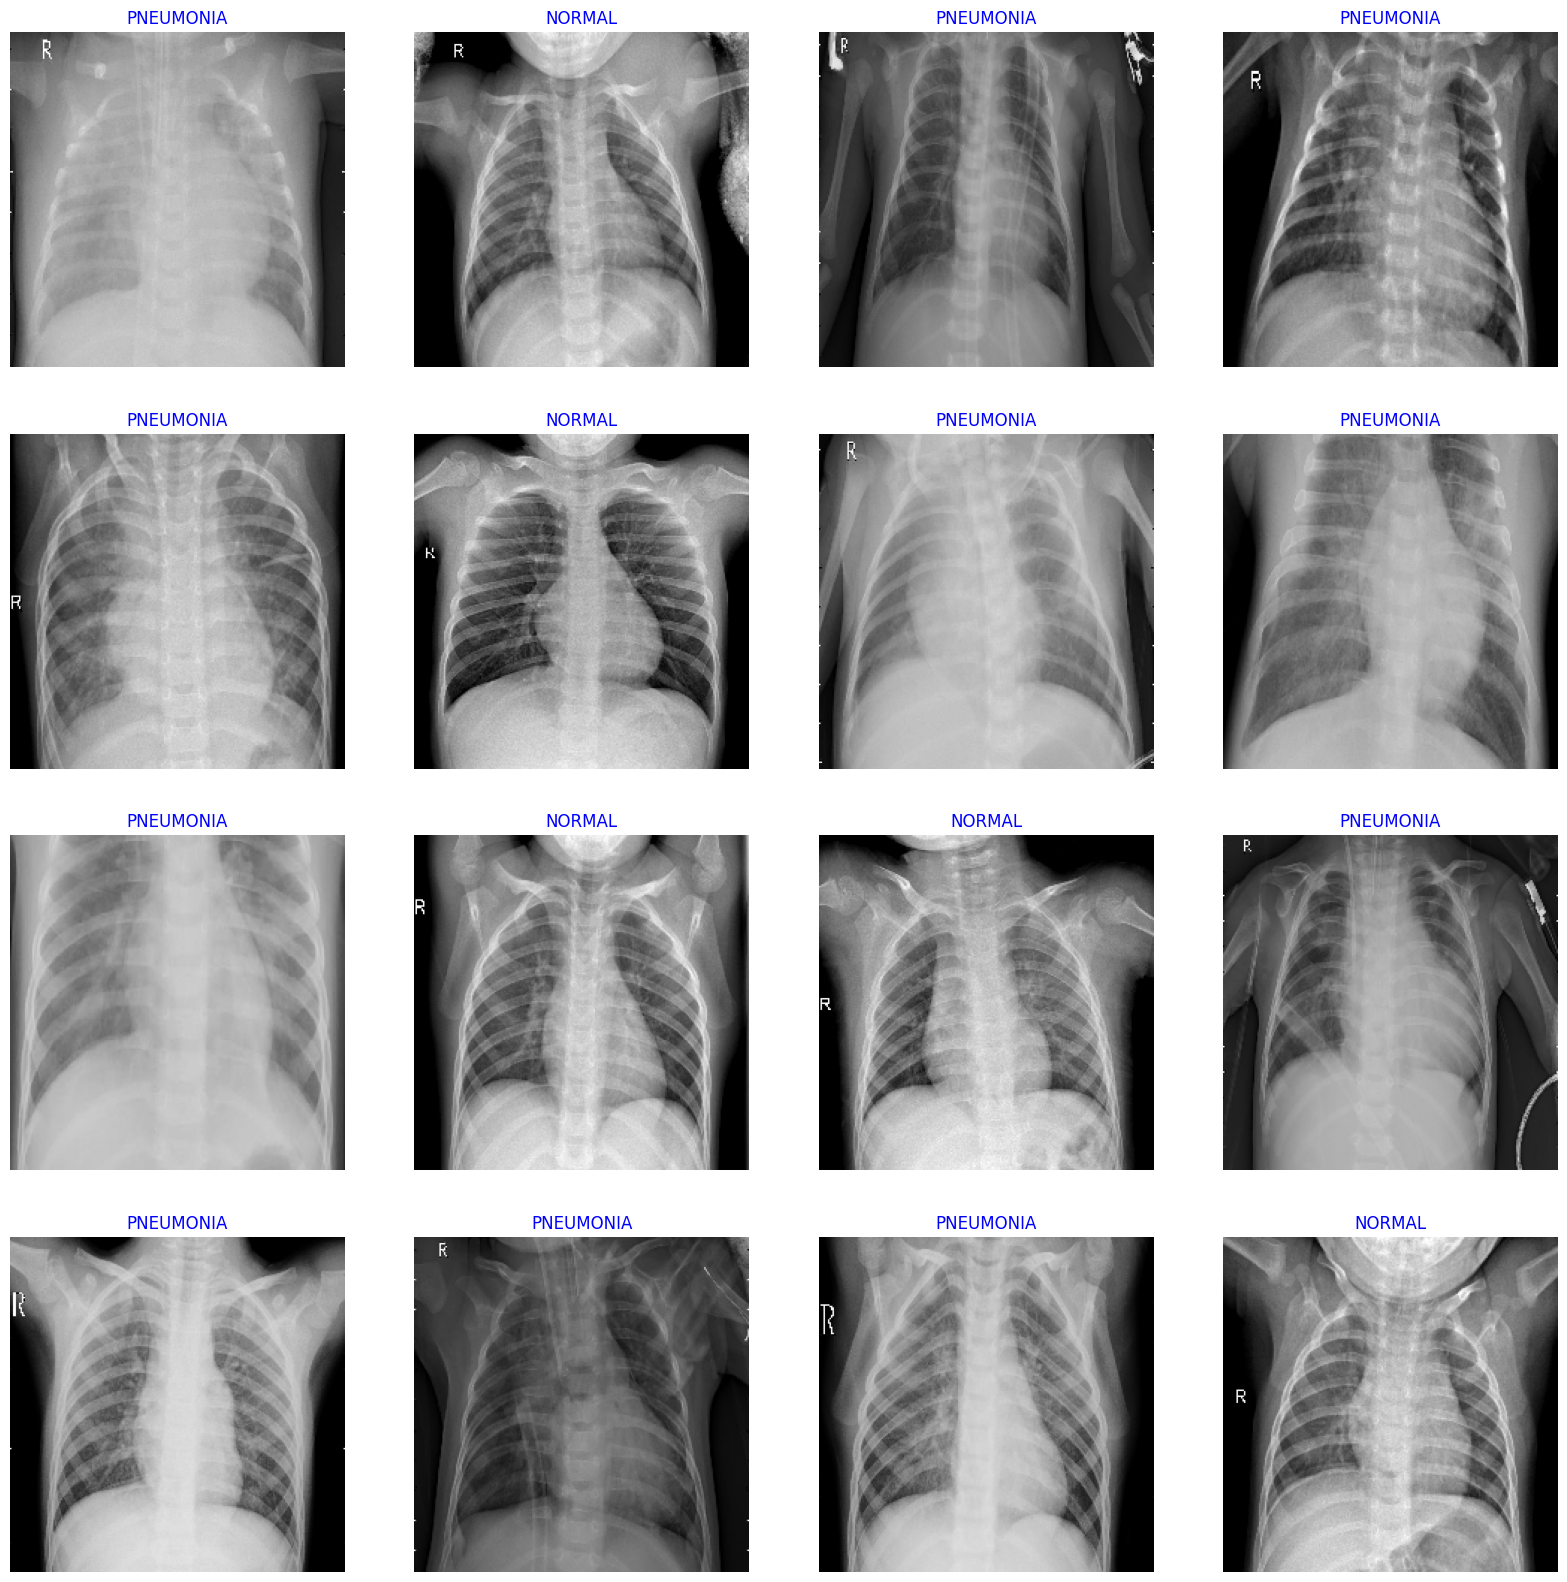

In [13]:
#Show Sample from the train data
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();


In [14]:
#model Structure
img_size = (224, 224)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet',input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])
model.compile(Adamax(learning_rate = 0.0001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11183665 (42.66 MB)
Trainable params: 1109

In [15]:
Epochs =5#to improve accuracy increase epoch as per your use
history = model.fit(x= train_gen , epochs = Epochs, verbose = 1, validation_data= valid_gen,validation_steps = None , shuffle = False)

Epoch 1/5
261/261 [==============================] - 2490s 9s/step - loss: 7.8810 - accuracy: 0.8188 - val_loss: 7.6090 - val_accuracy: 0.8019
Epoch 2/5
261/261 [==============================] - 2347s 9s/step - loss: 6.9096 - accuracy: 0.9293 - val_loss: 6.8810 - val_accuracy: 0.8115
Epoch 3/5
261/261 [==============================] - 2323s 9s/step - loss: 6.1544 - accuracy: 0.9533 - val_loss: 5.8090 - val_accuracy: 0.9649
Epoch 4/5
261/261 [==============================] - 2283s 9s/step - loss: 5.4791 - accuracy: 0.9607 - val_loss: 5.1768 - val_accuracy: 0.9824
Epoch 5/5
261/261 [==============================] - 2416s 9s/step - loss: 4.8996 - accuracy: 0.9655 - val_loss: 4.6575 - val_accuracy: 0.9824


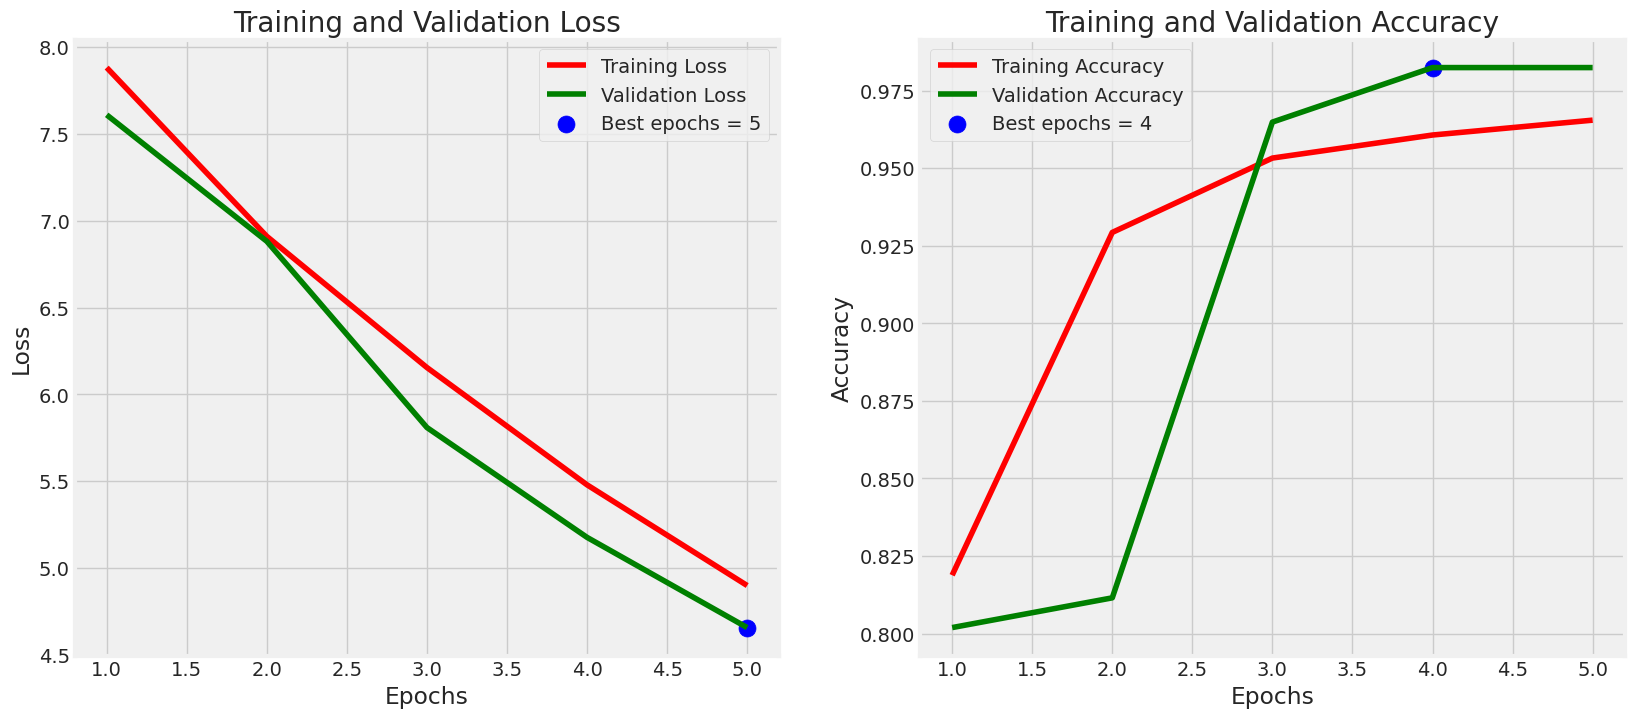

In [16]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();


In [17]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 61s 4s/step - loss: 4.6866 - accuracy: 0.9648
Train Loss:  4.6295061111450195
Train Accuracy:  0.99609375
--------------------
Validation Loss:  4.662745952606201
Validation Accuracy:  0.984375
--------------------
Test Loss:  4.686631679534912
Test Accuracy:  0.96484375


In [18]:
#Predictions
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

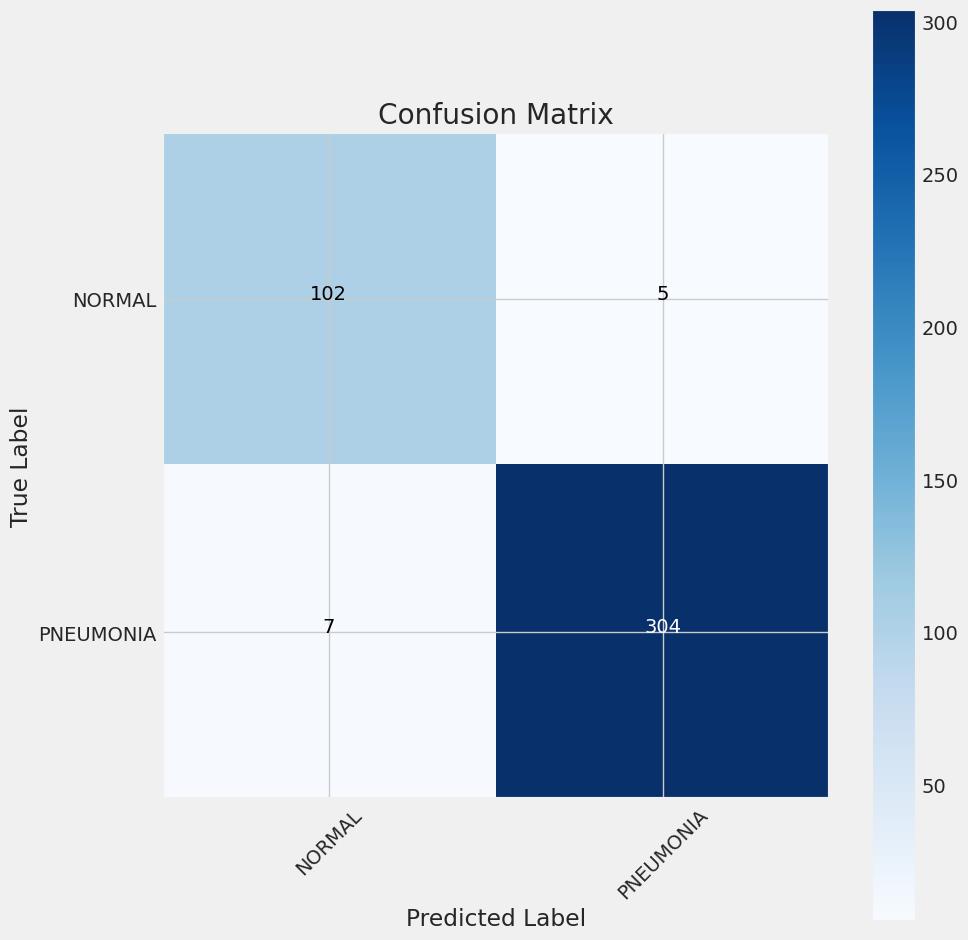

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      NORMAL       0.94      0.95      0.94       107
   PNEUMONIA       0.98      0.98      0.98       311

    accuracy                           0.97       418
   macro avg       0.96      0.97      0.96       418
weighted avg       0.97      0.97      0.97       418



In [21]:
!pip install pillow

1/1 [==============================] - 0s 456ms/step
72.373% likely to be pneumonia


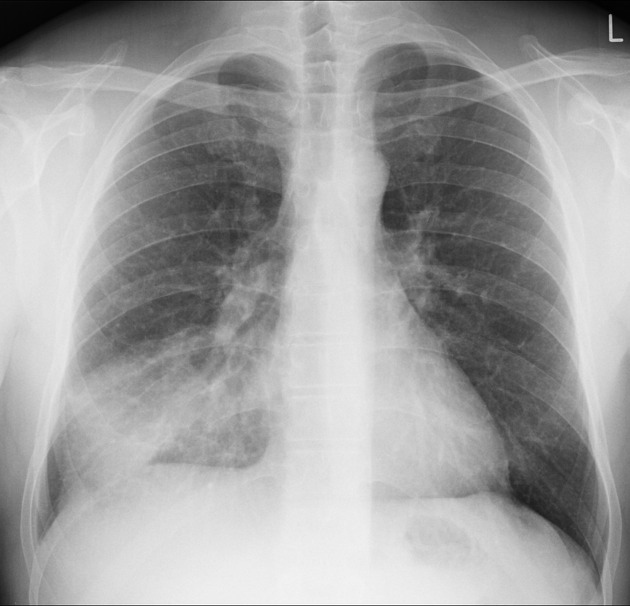

In [23]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
path_to_predict="/content/peno.jpeg"
predict=tf.keras.utils.load_img(
   path_to_predict,target_size=(224,224)
)
categories = ['NORMAL', 'PNEUMONIA']
convert_to_array=tf.keras.utils.img_to_array(predict)
convert_to_array=tf.expand_dims(convert_to_array,0)
prediction = model.predict(convert_to_array)
chance = tf.nn.softmax(prediction[0])
class_label = categories[np.argmax(chance)].lower()
confidence = 100 * np.max(chance)
print("{:.3f}% likely to be {}".format(confidence, class_label))
Image.open(path_to_predict)